In [110]:
import time
import pandas as pd
import os, math
import sys
import random
import subprocess
import matplotlib.pyplot as plt
from IPython.core.display import HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2



CB5_DIR = os.path.dirname(os.getcwd())
SIM_DIR=os.path.join(CB5_DIR,"sim")
SCRIPT_DIR = os.path.join(CB5_DIR,"scripts")
TRACES =os.path.join(CB5_DIR,"traces")
RESULT_DIR=os.path.join(CB5_DIR, "results")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# create a lists of workloads
workloads_83 = []
workloads_12 = []

all_works = sorted(os.listdir(TRACES))
length = ["LONG", "SHORT"]
types = ["MOBILE", "SERVER"]
for l in length:
    for t in types:
        temp_list = []
        for w in all_works:
            if (l + "_" + t) in w:
                temp_list.append(w)
        t10_list = random.sample(temp_list , k=min(3,len(temp_list)))
        temp_list = random.sample(temp_list , k=min(25,len(temp_list)))
        for _t in temp_list:
            workloads_83.append(_t)
        for _t in t10_list:
            workloads_12.append(_t)
            


In [23]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [24]:
policies = ["GHRP", "RANDOM", "LRU", "RRIP"]

cmd_base = [os.path.join(SIM_DIR,"predictor")]
# os.mkdir(os.path.join(RESULT_DIR,"12_works"))
print(workloads_12)
f = open(SCRIPT_DIR + "/12_works.sh", "w")
temp = os.path.join(RESULT_DIR,"exp_4bits")
for i in range(len(workloads_12)//2 + 1):
    for j in range(2):
        if (i*2+j < len(workloads_12)):
            for pol in policies:
                mycommand = cmd_base[:]
                mycommand.append(os.path.join(TRACES, workloads_12[i*2+j]))
                mycommand.append(pol)
                mycommand.append(">")
                a = mycommand[1].split("/")
                mycommand.append((temp +"/"+ a[-1] + mycommand[2] +".txt"))
                mycommand.append("&")
                mycommand = " ".join(mycommand)
                f.write(mycommand)
                f.write("\n")
    f.write("for pid in $(jobs -p)\n")
    f.write("do\n")
    f.write("\twait $pid\n")
    f.write("done\n")
        
f.close()              


['LONG_MOBILE-11.bt9.trace.gz', 'LONG_MOBILE-29.bt9.trace.gz', 'LONG_MOBILE-17.bt9.trace.gz', 'LONG_SERVER-7.bt9.trace.gz', 'LONG_SERVER-8.bt9.trace.gz', 'LONG_SERVER-2.bt9.trace.gz', 'SHORT_MOBILE-4.bt9.trace.gz', 'SHORT_MOBILE-44.bt9.trace.gz', 'SHORT_MOBILE-88.bt9.trace.gz', 'SHORT_SERVER-272.bt9.trace.gz', 'SHORT_SERVER-113.bt9.trace.gz', 'SHORT_SERVER-254.bt9.trace.gz']


In [33]:
workloads_12

['LONG_MOBILE-5.bt9.trace.gz',
 'LONG_MOBILE-3.bt9.trace.gz',
 'LONG_MOBILE-22.bt9.trace.gz',
 'LONG_SERVER-4.bt9.trace.gz',
 'LONG_SERVER-8.bt9.trace.gz',
 'LONG_SERVER-6.bt9.trace.gz',
 'SHORT_MOBILE-69.bt9.trace.gz',
 'SHORT_MOBILE-7.bt9.trace.gz',
 'SHORT_MOBILE-3.bt9.trace.gz',
 'SHORT_SERVER-85.bt9.trace.gz',
 'SHORT_SERVER-97.bt9.trace.gz',
 'SHORT_SERVER-203.bt9.trace.gz']

In [25]:
works12 = ['LONG_MOBILE-11.bt9.trace.gz', 'LONG_MOBILE-29.bt9.trace.gz', 'LONG_MOBILE-17.bt9.trace.gz', 'LONG_SERVER-7.bt9.trace.gz', 'LONG_SERVER-8.bt9.trace.gz', 'LONG_SERVER-2.bt9.trace.gz', 'SHORT_MOBILE-4.bt9.trace.gz', 'SHORT_MOBILE-44.bt9.trace.gz', 'SHORT_MOBILE-88.bt9.trace.gz', 'SHORT_SERVER-272.bt9.trace.gz', 'SHORT_SERVER-113.bt9.trace.gz', 'SHORT_SERVER-254.bt9.trace.gz']

In [39]:
policies = ["GHRP", "RANDOM", "LRU", "RRIP"]

print(workloads_12)

temp = os.path.join(RESULT_DIR,"exp_4bits")
Tot_data = dict()
Tot_data["RPs"] = policies
for i in range(len(workloads_12)):
    miss_rates = dict()
    for pol in policies:
        f = open(temp + "/"+workloads_12[i] + pol + ".txt", "r" )

        miss_rates[pol] = []
        for line in f.readlines():
            l = line.strip().split(":")
            if len(l)>0:
                if l[0] == "MissRate (misses per 1000 insts)":
                    miss_rates[pol].append(float(l[1]))
                    
        f.close()

    ind = len(miss_rates[policies[0]])
    for k in miss_rates.keys():
        ind  = min(len(miss_rates[k]), ind)
    w = workloads_12[i].split(".")
    Tot_data[w[0]] = []
    for pol in policies:
        Tot_data[w[0]].append(miss_rates[pol][ind-1])
df = pd.DataFrame(Tot_data)
#               f.write(mycommand)
#               f.write("\n")
#     f.write("for pid in $(jobs -p)\n")
#     f.write("do\n")
#     f.write("\twait $pid\n")
#     f.write("done\n")
df.set_index("RPs",inplace =True)
df

['LONG_MOBILE-11.bt9.trace.gz', 'LONG_MOBILE-29.bt9.trace.gz', 'LONG_MOBILE-17.bt9.trace.gz', 'LONG_SERVER-7.bt9.trace.gz', 'LONG_SERVER-8.bt9.trace.gz', 'LONG_SERVER-2.bt9.trace.gz', 'SHORT_MOBILE-4.bt9.trace.gz', 'SHORT_MOBILE-44.bt9.trace.gz', 'SHORT_MOBILE-88.bt9.trace.gz', 'SHORT_SERVER-272.bt9.trace.gz', 'SHORT_SERVER-113.bt9.trace.gz', 'SHORT_SERVER-254.bt9.trace.gz']


,LONG_MOBILE-11,LONG_MOBILE-29,LONG_MOBILE-17,LONG_SERVER-7,LONG_SERVER-8,LONG_SERVER-2,SHORT_MOBILE-4,SHORT_MOBILE-44,SHORT_MOBILE-88,SHORT_SERVER-272,SHORT_SERVER-113,SHORT_SERVER-254
RPs,,,,,,,,,,,,
GHRP,0.0370,0.0211,7.029801,4.1178,2.0439,425.921543,6.703719,0.158271,0.00461,22.528913,24.721829,48.343326
RANDOM,0.0358,0.0211,3.456900,3.2950,1.0674,372.706337,6.741595,0.158141,0.00461,19.934112,24.700870,38.428304
LRU,0.0370,0.0211,6.977101,4.2092,2.3840,373.733237,6.740438,0.158271,0.00461,22.002383,24.681751,38.165757
RRIP,0.0354,0.0211,2.767200,2.7332,0.8779,363.166836,6.703602,0.150598,0.00461,16.271907,24.645752,35.738290


In [55]:
df_1 = df.copy()
cols = df.columns
for col in cols:
    df_1[col] = df_1[col]/df_1[col]["LRU"]
df_1

,LONG_MOBILE-11,LONG_MOBILE-29,LONG_MOBILE-17,LONG_SERVER-7,LONG_SERVER-8,LONG_SERVER-2,SHORT_MOBILE-4,SHORT_MOBILE-44,SHORT_MOBILE-88,SHORT_SERVER-272,SHORT_SERVER-113,SHORT_SERVER-254
RPs,,,,,,,,,,,,
GHRP,1.000000,1.0,1.007553,0.978286,0.857341,1.139641,0.994552,1.000000,1.0,1.023931,1.001624,1.266668
RANDOM,0.967568,1.0,0.495464,0.782809,0.447735,0.997252,1.000172,0.999178,1.0,0.905998,1.000775,1.006879
LRU,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
RRIP,0.956757,1.0,0.396612,0.649340,0.368247,0.971727,0.994535,0.951520,1.0,0.739552,0.998541,0.936397


In [47]:
length = ["LONG", "SHORT"]
types = ["MOBILE", "SERVER"]

All = ["LONG_SERVER", "SHORT_MOBILE"]
workloads_28 = []
for l in All:
    temp_list = []
    for w in all_works:
        if (l) in w:
            temp_list.append(w)
    if l=="SHORT_MOBILE":
        temp_list = random.sample(temp_list , k=min(23,len(temp_list)))
    if l=="LONG_SERVER":
        temp_list = random.sample(temp_list , k=min(5,len(temp_list)))
    for _t in temp_list:
        workloads_28.append(_t)

workloads_28

['LONG_SERVER-1.bt9.trace.gz',
 'LONG_SERVER-7.bt9.trace.gz',
 'LONG_SERVER-6.bt9.trace.gz',
 'LONG_SERVER-8.bt9.trace.gz',
 'LONG_SERVER-4.bt9.trace.gz',
 'SHORT_MOBILE-36.bt9.trace.gz',
 'SHORT_MOBILE-41.bt9.trace.gz',
 'SHORT_MOBILE-69.bt9.trace.gz',
 'SHORT_MOBILE-15.bt9.trace.gz',
 'SHORT_MOBILE-72.bt9.trace.gz',
 'SHORT_MOBILE-52.bt9.trace.gz',
 'SHORT_MOBILE-57.bt9.trace.gz',
 'SHORT_MOBILE-63.bt9.trace.gz',
 'SHORT_MOBILE-107.bt9.trace.gz',
 'SHORT_MOBILE-50.bt9.trace.gz',
 'SHORT_MOBILE-65.bt9.trace.gz',
 'SHORT_MOBILE-16.bt9.trace.gz',
 'SHORT_MOBILE-70.bt9.trace.gz',
 'SHORT_MOBILE-84.bt9.trace.gz',
 'SHORT_MOBILE-46.bt9.trace.gz',
 'SHORT_MOBILE-43.bt9.trace.gz',
 'SHORT_MOBILE-11.bt9.trace.gz',
 'SHORT_MOBILE-30.bt9.trace.gz',
 'SHORT_MOBILE-73.bt9.trace.gz',
 'SHORT_MOBILE-103.bt9.trace.gz',
 'SHORT_MOBILE-17.bt9.trace.gz',
 'SHORT_MOBILE-31.bt9.trace.gz',
 'SHORT_MOBILE-90.bt9.trace.gz']

In [90]:
policies = ["GHRP", "RANDOM", "LRU", "RRIP"]

cmd_base = [os.path.join(SIM_DIR,"predictor")]
# os.mkdir(os.path.join(RESULT_DIR,"28_works"))
print(workloads_28)
f = open(SCRIPT_DIR + "/28_works.sh", "w")
temp = os.path.join(RESULT_DIR,"28_works")
for i in range(len(workloads_28)//2 + 1):
    for j in range(2):
        if (i*2+j < len(workloads_28)):
            for pol in policies:
                mycommand = cmd_base[:]
                mycommand.append(os.path.join(TRACES, workloads_28[i*2+j]))
                mycommand.append(pol)
                mycommand.append(">")
                a = mycommand[1].split("/")
                mycommand.append((temp +"/"+ a[-1] + mycommand[2] +".txt"))
                mycommand.append("&")
                mycommand = " ".join(mycommand)
                f.write(mycommand)
                f.write("\n")
    f.write("for pid in $(jobs -p)\n")
    f.write("do\n")
    f.write("\twait $pid\n")
    f.write("done\n")
        
f.close()         

['LONG_SERVER-1.bt9.trace.gz', 'LONG_SERVER-7.bt9.trace.gz', 'LONG_SERVER-6.bt9.trace.gz', 'LONG_SERVER-8.bt9.trace.gz', 'LONG_SERVER-4.bt9.trace.gz', 'SHORT_MOBILE-36.bt9.trace.gz', 'SHORT_MOBILE-41.bt9.trace.gz', 'SHORT_MOBILE-69.bt9.trace.gz', 'SHORT_MOBILE-15.bt9.trace.gz', 'SHORT_MOBILE-72.bt9.trace.gz', 'SHORT_MOBILE-52.bt9.trace.gz', 'SHORT_MOBILE-57.bt9.trace.gz', 'SHORT_MOBILE-63.bt9.trace.gz', 'SHORT_MOBILE-107.bt9.trace.gz', 'SHORT_MOBILE-50.bt9.trace.gz', 'SHORT_MOBILE-65.bt9.trace.gz', 'SHORT_MOBILE-16.bt9.trace.gz', 'SHORT_MOBILE-70.bt9.trace.gz', 'SHORT_MOBILE-84.bt9.trace.gz', 'SHORT_MOBILE-46.bt9.trace.gz', 'SHORT_MOBILE-43.bt9.trace.gz', 'SHORT_MOBILE-11.bt9.trace.gz', 'SHORT_MOBILE-30.bt9.trace.gz', 'SHORT_MOBILE-73.bt9.trace.gz', 'SHORT_MOBILE-103.bt9.trace.gz', 'SHORT_MOBILE-17.bt9.trace.gz', 'SHORT_MOBILE-31.bt9.trace.gz', 'SHORT_MOBILE-90.bt9.trace.gz']


In [93]:
policies = ["GHRP", "RANDOM", "LRU", "RRIP"]

print(workloads_28)

temp = os.path.join(RESULT_DIR,"28_works")
Tot_data_28 = dict()
Tot_data_28["RPs"] = policies
for i in range(len(workloads_28)):
    miss_rates = dict()
    for pol in policies:
        if os.path.exists(temp + "/"+workloads_28[i] + pol + ".txt"):
            f = open(temp + "/"+workloads_28[i] + pol + ".txt", "r" )

            miss_rates[pol] = []
            for line in f.readlines():
                l = line.strip().split(":")
                if len(l)>0:
                    if l[0] == "MissRate (misses per 1000 insts)":
                        miss_rates[pol].append(float(l[1]))

            f.close()
    if len(miss_rates.keys()) > 0:
        ind = len(miss_rates[policies[0]])
        for k in miss_rates.keys():
            ind  = min(len(miss_rates[k]), ind)
        w = workloads_28[i].split(".")
        Tot_data_28[w[0]] = []
        for pol in policies:
            Tot_data_28[w[0]].append(miss_rates[pol][ind-1])
df_28 = pd.DataFrame(Tot_data_28)
#               f.write(mycommand)
#               f.write("\n")
#     f.write("for pid in $(jobs -p)\n")
#     f.write("do\n")
#     f.write("\twait $pid\n")
#     f.write("done\n")
df_28.set_index("RPs",inplace =True)
df_28

['LONG_SERVER-1.bt9.trace.gz', 'LONG_SERVER-7.bt9.trace.gz', 'LONG_SERVER-6.bt9.trace.gz', 'LONG_SERVER-8.bt9.trace.gz', 'LONG_SERVER-4.bt9.trace.gz', 'SHORT_MOBILE-36.bt9.trace.gz', 'SHORT_MOBILE-41.bt9.trace.gz', 'SHORT_MOBILE-69.bt9.trace.gz', 'SHORT_MOBILE-15.bt9.trace.gz', 'SHORT_MOBILE-72.bt9.trace.gz', 'SHORT_MOBILE-52.bt9.trace.gz', 'SHORT_MOBILE-57.bt9.trace.gz', 'SHORT_MOBILE-63.bt9.trace.gz', 'SHORT_MOBILE-107.bt9.trace.gz', 'SHORT_MOBILE-50.bt9.trace.gz', 'SHORT_MOBILE-65.bt9.trace.gz', 'SHORT_MOBILE-16.bt9.trace.gz', 'SHORT_MOBILE-70.bt9.trace.gz', 'SHORT_MOBILE-84.bt9.trace.gz', 'SHORT_MOBILE-46.bt9.trace.gz', 'SHORT_MOBILE-43.bt9.trace.gz', 'SHORT_MOBILE-11.bt9.trace.gz', 'SHORT_MOBILE-30.bt9.trace.gz', 'SHORT_MOBILE-73.bt9.trace.gz', 'SHORT_MOBILE-103.bt9.trace.gz', 'SHORT_MOBILE-17.bt9.trace.gz', 'SHORT_MOBILE-31.bt9.trace.gz', 'SHORT_MOBILE-90.bt9.trace.gz']


,LONG_SERVER-1,LONG_SERVER-7,LONG_SERVER-6,LONG_SERVER-8,LONG_SERVER-4,SHORT_MOBILE-36,SHORT_MOBILE-41,SHORT_MOBILE-69,SHORT_MOBILE-15,SHORT_MOBILE-72,...,SHORT_MOBILE-84,SHORT_MOBILE-46,SHORT_MOBILE-43,SHORT_MOBILE-11,SHORT_MOBILE-30,SHORT_MOBILE-73,SHORT_MOBILE-103,SHORT_MOBILE-17,SHORT_MOBILE-31,SHORT_MOBILE-90
RPs,,,,,,,,,,,,,,,,,,,,,
GHRP,81.845408,4.1178,13.089401,2.0439,74.130907,6.639301,0.0006,0.0204,0.064058,0.023849,...,0.044661,3.022046,0.017331,50.316572,0.445633,0.022727,0.002091,0.044620,0.026984,0.493391
RANDOM,89.248309,3.2950,7.035101,1.0674,57.005306,3.403000,0.0006,0.0204,0.064399,0.023849,...,0.043921,3.022046,0.017331,50.150795,0.447054,0.022727,0.002091,0.041750,0.027157,0.520044
LRU,81.694408,4.2092,13.088901,2.3840,65.304307,6.650201,0.0006,0.0204,0.064058,0.023849,...,0.044661,3.022046,0.017331,49.365414,0.445633,0.022727,0.002091,0.044654,0.026984,0.494006
RRIP,81.167608,2.7332,5.654401,0.8779,54.199205,2.708100,0.0006,0.0204,0.064126,0.023849,...,0.043459,3.022046,0.017331,47.833265,0.447054,0.022727,0.002091,0.040930,0.027157,0.493084


In [99]:
df_28_1 = df_28.copy()
cols = df_28_1.columns
for col in cols:
    df_28_1[col] = df_28_1[col]/df_28_1[col]["LRU"]
df_28_1.iloc[:,14:]

,SHORT_MOBILE-50,SHORT_MOBILE-65,SHORT_MOBILE-16,SHORT_MOBILE-70,SHORT_MOBILE-84,SHORT_MOBILE-46,SHORT_MOBILE-43,SHORT_MOBILE-11,SHORT_MOBILE-30,SHORT_MOBILE-73,SHORT_MOBILE-103,SHORT_MOBILE-17,SHORT_MOBILE-31,SHORT_MOBILE-90
RPs,,,,,,,,,,,,,,
GHRP,1.000000,1.000000,0.986296,1.0,1.000000,1.0,1.0,1.019268,1.000000,1.0,1.0,0.999235,1.000000,0.998755
RANDOM,1.005507,1.130366,0.868536,1.0,0.983437,1.0,1.0,1.015910,1.003188,1.0,1.0,0.934966,1.006403,1.052708
LRU,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000
RRIP,1.001101,0.899046,0.756441,1.0,0.973085,1.0,1.0,0.968963,1.003188,1.0,1.0,0.916603,1.006403,0.998132


In [154]:
df_3 = pd.DataFrame()
df_3 = df_3.append(df[df.columns[[1,3,4,6,8,11]]])
df_3 = df_3.merge(df_28[df_28.columns[[1,5,6,8,9,14,27,24,22]]])

df_3["RPs"] = policies
df_3["SHORT_MOBILE-91"] = [0.703926491, 0.734239581, 0.708799978,0.698370715]
df_3.set_index("RPs",inplace =True)


df_3_1 = df_3.copy()
for col in df_3.columns:
    df_3_1[col] = df_3_1[col]/df_3_1[col]["LRU"]
display(df_3[df_3_1.columns[0:len(df_3_1.columns)//2]])
display(df_3[df_3_1.columns[len(df_3_1.columns)//2:len(df_3_1.columns)]])

,LONG_MOBILE-29,LONG_SERVER-7,LONG_SERVER-8,SHORT_MOBILE-4,SHORT_MOBILE-88,SHORT_SERVER-254,SHORT_MOBILE-36
RPs,,,,,,,
GHRP,0.0211,4.1178,2.0439,6.703719,0.00461,48.343326,6.639301
RANDOM,0.0211,3.2950,1.0674,6.741595,0.00461,38.428304,3.403000
LRU,0.0211,4.2092,2.3840,6.740438,0.00461,38.165757,6.650201
RRIP,0.0211,2.7332,0.8779,6.703602,0.00461,35.738290,2.708100


,SHORT_MOBILE-41,SHORT_MOBILE-15,SHORT_MOBILE-72,SHORT_MOBILE-50,SHORT_MOBILE-90,SHORT_MOBILE-103,SHORT_MOBILE-30,SHORT_MOBILE-91
RPs,,,,,,,,
GHRP,0.0006,0.064058,0.023849,0.128655,0.493391,0.002091,0.445633,0.703926
RANDOM,0.0006,0.064399,0.023849,0.129364,0.520044,0.002091,0.447054,0.734240
LRU,0.0006,0.064058,0.023849,0.128655,0.494006,0.002091,0.445633,0.708800
RRIP,0.0006,0.064126,0.023849,0.128797,0.493084,0.002091,0.447054,0.698371


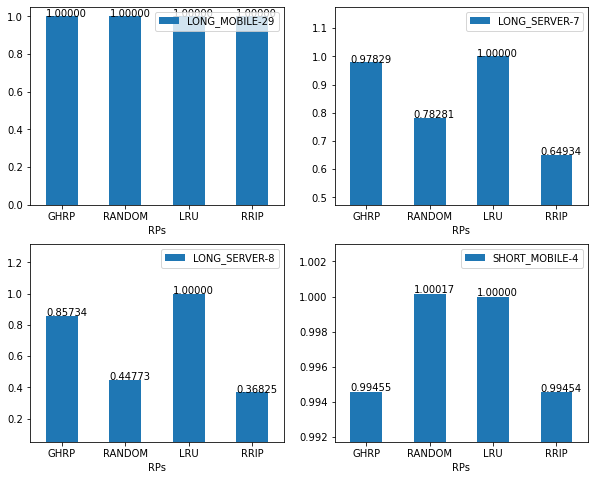

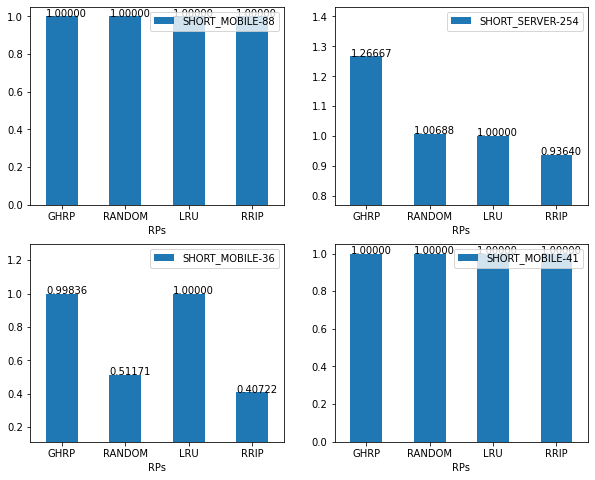

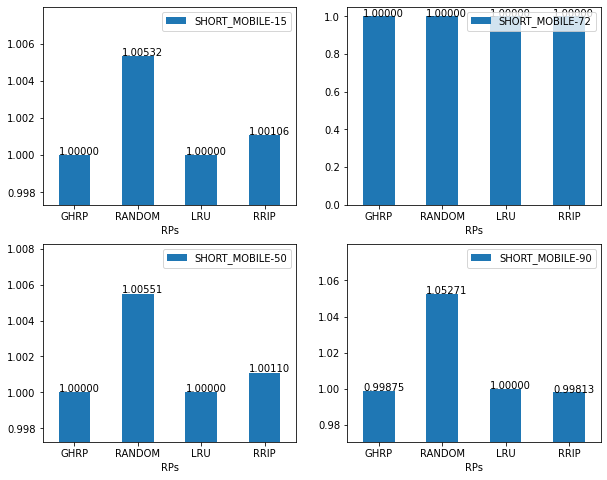

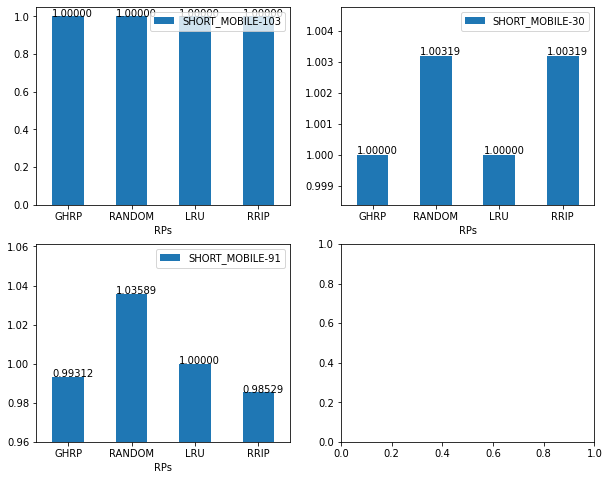

In [161]:
for i in range(len(df_3_1.columns)//4 + 1):

    fig, axes = plt.subplots(nrows=2, ncols=2)
    axs = []
    for j in range(4):
        if i*4 + j < len(df_3_1.columns):
            high = min(df_3_1[df_3_1.columns[i*4 + j]])
            low = max(df_3_1[df_3_1.columns[i*4 + j]]) 
            
            if high ==low:
                ax_temp =  df_3_1[df_3_1.columns[i*4 + j]].plot(ax = axes[j//2, j%2],legend = True,  kind = 'bar', rot = 0)
                
            else:
                ax_temp =  df_3_1[df_3_1.columns[i*4 + j]].plot(ax = axes[j//2, j%2], legend = True, ylim = [(high+0.5*(high-low)),(low-0.5*(high-low))], kind = 'bar', rot = 0)
                
#             ax1 = df_3_1[df_3.columns[i*4]].plot(ax = axes[0,0],kind='bar', rot =0)
            
#             ax0 = df_3_1[["SHORT_MOBILE-91"]].plot(kind='bar' , ylim = [(high+0.5*(high-low)),(low-0.5*(high-low))])
            for p in ax_temp.patches:
                ax_temp.annotate("{:.5f}".format(p.get_height()), (p.get_x() * 1.00005, p.get_height() * 1.00005))
            axs.append(ax_temp)

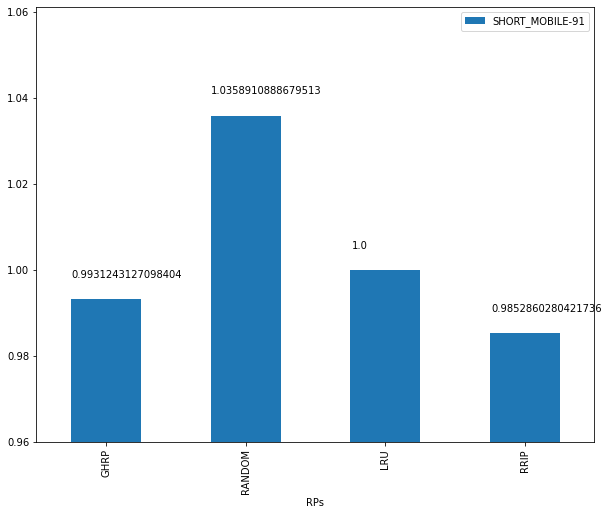

In [136]:
high = min(df_3_1["SHORT_MOBILE-91"])
low = max(df_3_1["SHORT_MOBILE-91"])
ax0 = df_3_1[["SHORT_MOBILE-91"]].plot(kind='bar' , ylim = [(high+0.5*(high-low)),(low-0.5*(high-low))])
for p in ax0.patches:
    ax0.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.show(block=True)
# ax0.set_ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])


,avg. MPKI
GHRP,0.987173
RANDOM,0.917503
LRU,1.000000
RRIP,0.886294


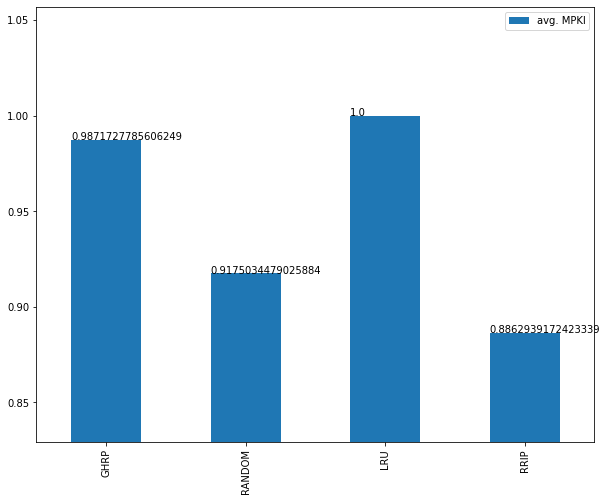

In [188]:
tot_res = pd.Series([0,0,0,0], index = policies)
for i in range(len(df_3_1.columns)):
    if df_3_1.columns[i] == "SHORT_SERVER-254":
        continue
    else:
        tot_res += df_3_1[df_3_1.columns[i]]
tot_res /= 14
tot_res_df = pd.DataFrame(tot_res)
tot_res_df.columns = ["avg. MPKI"] 
display(tot_res_df)
high = max(tot_res_df["avg. MPKI"])
low = min(tot_res_df["avg. MPKI"])
ax_tot = tot_res_df.plot(kind='bar' , ylim = [(low-0.5*(high-low)),(high+0.5*(high-low))])
for p in ax_tot.patches:
    ax_tot.annotate(str(p.get_height()), (p.get_x() * 1.0000005, p.get_height() * 1.00005))